Tutorial 3: Fitting
===================

In previous tutorials, we used light profiles to create simulated images of galaxies and visualized how these images
would appear when captured by a CCD detector on a telescope like the Hubble Space Telescope.

However, this simulation process is the reverse of what astronomers typically do when analyzing real data. Usually,
astronomers start with an observation—an actual image of a galaxy—and aim to infer detailed information about the
galaxy’s properties, such as its shape, structure, formation, and evolutionary history.

To achieve this, we must fit the observed image data with a model, identifying the combination of light profiles that
best matches the galaxy's appearance in the image. In this tutorial, we'll illustrate this process using the imaging
data simulated in the previous tutorial. Our goal is to demonstrate how we can recover the parameters of the light
profiles that we used to create the original simulation, as a proof of concept for the fitting procedure.

The process of fitting data introduces essential statistical concepts like the `model`, `residual_map`, `chi-squared`,
`likelihood`, and `noise_map`. These terms are crucial for understanding how fitting works, not only in astronomy but
also in any scientific field that involves data modeling. This tutorial will provide a detailed introduction to these
concepts and show how they are applied in practice to analyze astronomical data.

Here is an overview of what we'll cover in this tutorial:

- **Dataset**: Load the imaging dataset that we previously simulated, consisting of the image, noise map, and PSF.
- **Mask**: Apply a mask to the data, excluding regions with low signal-to-noise ratios from the analysis.
- **Masked Grid**: Create a masked grid, which contains only the coordinates of unmasked pixels, to evaluate the
  galaxy's light profile in only unmasked regions.
- **Fitting**: Fit the data with a galaxy model, computing key quantities like the model image, residuals,
  chi-squared, and log likelihood to assess the quality of the fit.
- **Bad Fits**: Demonstrate how even small deviations from the true parameters can significantly impact the fit.
- **Model Fitting**: Perform a basic model fit on a simple dataset, adjusting the model parameters to improve the
  fit quality.

In [1]:
import numpy as np
from os import path
import autogalaxy as ag
import autogalaxy.plot as aplt

__Dataset__

We begin by loading the imaging dataset that we will use for fitting in this tutorial. This dataset is identical to the 
one we simulated in the previous tutorial, representing how a galaxy would appear if captured by a CCD camera.

In the previous tutorial, we saved this dataset as .fits files in the `autogalaxy_workspace/dataset/imaging/simple_example` 
folder. The `.fits` format is commonly used in astronomy for storing image data along with metadata, making it a
standard for CCD imaging.

The `dataset_path` below specifies where these files are located: `autogalaxy_workspace/dataset/imaging/simple_example/`.

In [2]:
dataset_path = path.join("dataset", "imaging", "simple_example")

dataset = ag.Imaging.from_fits(
    data_path=path.join(dataset_path, "data.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

The `Imaging` object contains three key components: `data`, `noise_map`, and `psf`:

- `data`: The actual image of the galaxy, which we will analyze.

- `noise_map`: A map indicating the uncertainty or noise level in each pixel of the image, reflecting how much the 
  observed signal in each pixel might fluctuate due to instrumental or background noise.
  
- `psf`: The Point Spread Function, which describes how a point source of light is spread out in the image by the 
  telescope's optics. It characterizes the blurring effect introduced by the instrument.

Let's print some values from these components and plot a summary of the dataset to refresh our understanding of the 
imaging data.

Value of first pixel in imaging data:
0.030789117297154694
Value of first pixel in noise map:
0.020879744354849007
Value of first pixel in PSF:
2.210334945638401e-12


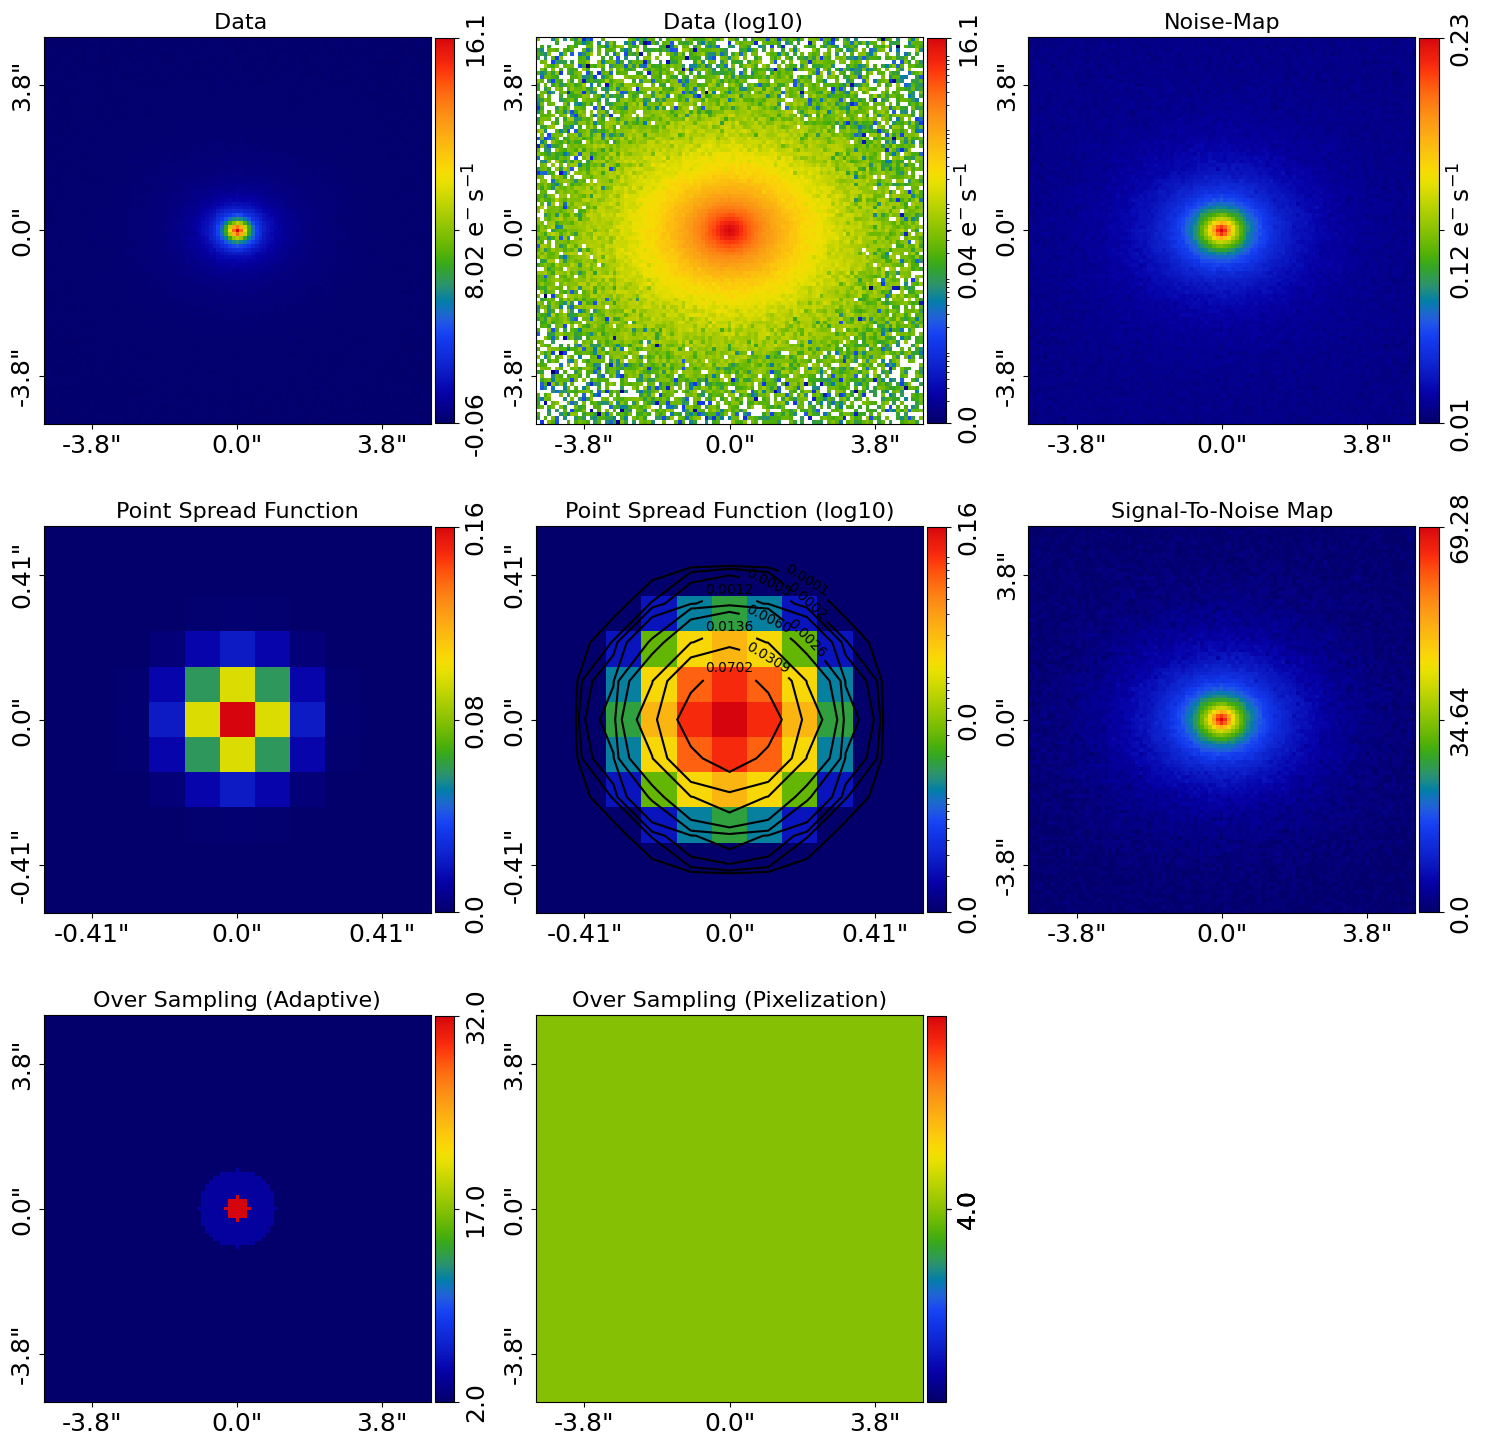

In [3]:
print("Value of first pixel in imaging data:")
print(dataset.data.native[0, 0])
print("Value of first pixel in noise map:")
print(dataset.noise_map.native[0, 0])
print("Value of first pixel in PSF:")
print(dataset.psf.native[0, 0])

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.subplot_dataset()

__Mask__

The signal-to-noise map of the image highlights areas where the signal (light from the galaxy) is detected above the 
background noise. Values above 3.0 indicate regions where the galaxy's light is detected with a signal-to-noise ratio
of at least 3, while values below 3.0 are dominated by noise, where the galaxy's light is not clearly distinguishable.

To ensure the fitting process focuses only on meaningful data, we typically mask out regions with low signal-to-noise 
ratios, removing areas dominated by noise from the analysis. This allows the fitting process to concentrate on the 
regions where the galaxy is clearly detected.

Here, we create a `Mask2D` to exclude certain regions of the image from the analysis. The mask defines which parts of 
the image will be used during the fitting process.

For our simulated image, a circular 3" mask centered at the center of the image is appropriate, since the simulated 
galaxy was positioned at the center.

In [4]:
mask = ag.Mask2D.circular(
    shape_native=dataset.shape_native,
    pixel_scales=dataset.pixel_scales,
    radius=3.0,  # The circular mask's radius in arc-seconds
    centre=(0.0, 0.0),  # center of the image which is also the center of the galaxy
)

print(mask)  # 1 = True, meaning the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53])  # Central pixels are `False` and therefore unmasked.

Mask2D([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Mask2D([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])


We can visualize the mask over the galaxy image using an `ImagingPlotter`, which helps us adjust the mask as needed. 
This is useful to ensure that the mask appropriately covers the galaxy's light and does not exclude important regions.

To overlay objects like a mask onto a figure, we use the `Visuals2D` object. This tool allows us to add custom 
visuals to any plot, providing flexibility in creating tailored visual representations.

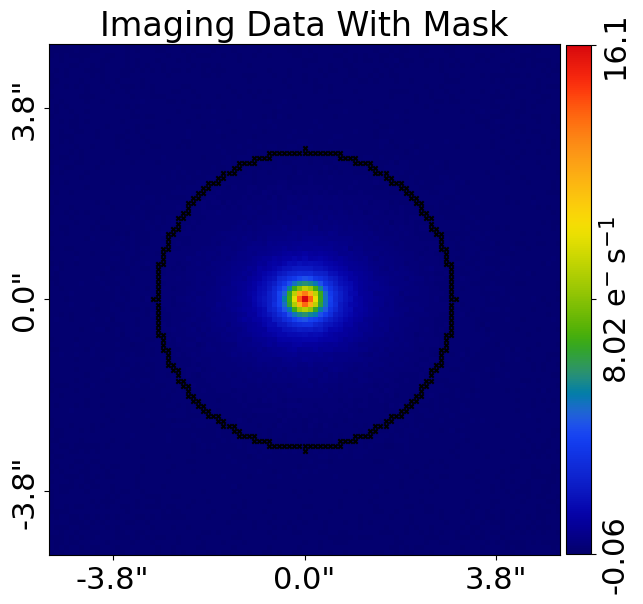

In [5]:
visuals = aplt.Visuals2D(mask=mask)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset, visuals_2d=visuals)
dataset_plotter.set_title("Imaging Data With Mask")
dataset_plotter.figures_2d(data=True)

Once we are satisfied with the mask, we apply it to the imaging data using the `apply_mask()` method. This ensures 
that only the unmasked regions are considered during the analysis.

In [6]:
dataset = dataset.apply_mask(mask=mask)

2024-10-30 12:09:34,403 - autoarray.dataset.imaging.dataset - INFO - IMAGING - Data masked, contains a total of 2813 image-pixels


When we plot the masked imaging data again, the mask is now automatically included in the plot, even though we did 
not explicitly pass it using the `Visuals2D` object. The plot also zooms into the unmasked area, showing only the 
region where we will focus our analysis. This is particularly helpful when working with large images, as it centers 
the view on the regions where the galaxy's signal is detected.

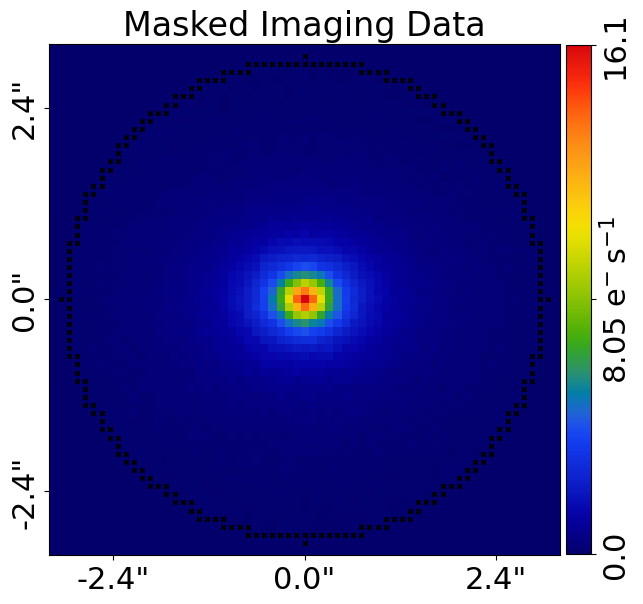

In [7]:
dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.set_title("Masked Imaging Data")
dataset_plotter.figures_2d(data=True)

The mask is now stored as an additional attribute of the `Imaging` object, meaning it remains attached to the 
dataset. This makes it readily available when we pass the dataset to a `FitImaging` object for the fitting process.

In [8]:
print("Mask2D:")
print(dataset.mask)

Mask2D:
Mask2D([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])


In earlier tutorials, we discussed how grids and arrays have `native` and `slim` representations:

- `native`: Represents the original 2D shape of the data, maintaining the full pixel array of the image.
- `slim`: Represents a 1D array containing only the values from unmasked pixels, allowing for more efficient 
  processing when working with large images.

After applying the mask, the `native` and `slim` representations change as follows:

- `native`: The 2D array keeps its original shape, [total_y_pixels, total_x_pixels], but masked pixels (those where 
  the mask is True) are set to 0.0.
- `slim`: This now only contains the unmasked pixel values, reducing the array size 
  from [total_y_pixels * total_x_pixels] to just the number of unmasked pixels.

Let's verify this by checking the shape of the data in its `slim` representation.

In [9]:
print("Number of unmasked pixels:")
print(dataset.data.native.shape)
print(
    dataset.data.slim.shape
)  # This should be lower than the total number of pixels, e.g., 100 x 100 = 10,000

Number of unmasked pixels:
(101, 101)
(2813,)


The `mask` object also has a `pixels_in_mask` attribute, which gives the number of unmasked pixels. This should 
match the size of the `slim` data structure.

In [10]:
print(dataset.data.mask.pixels_in_mask)

2813


We can use the `slim` attribute to print the first unmasked values from the image and noise map:

In [11]:
print("First unmasked image value:")
print(dataset.data.slim[0])
print("First unmasked noise map value:")
print(dataset.noise_map.slim[0])

First unmasked image value:
0.09970867745569997
First unmasked noise map value:
0.02580107733252625


Additionally, we can verify that the `native` data structure has zeros at the edges where the mask is applied and 
retains non-zero values in the central unmasked regions.

In [12]:
print("Example masked pixel in the image's native representation at its edge:")
print(dataset.data.native[0, 0])
print("Example unmasked pixel in the image's native representation at its center:")
print(dataset.data.native[48, 48])

Example masked pixel in the image's native representation at its edge:
0.0
Example unmasked pixel in the image's native representation at its center:
6.703144872628471


__Masked Grid__

In tutorial 1, we emphasized that the `Grid2D` object is crucial for evaluating a galaxy's light profile. This grid 
contains (y, x) coordinates for each pixel in the image and is used to map out the positions where the galaxy's 
light is calculated.

From a `Mask2D`, we derive a `masked_grid`, which consists only of the coordinates of unmasked pixels. This ensures 
that light profile calculations focus exclusively on regions where the galaxy's light is detected, saving computational 
time and improving efficiency.

Below, we plot the masked grid:

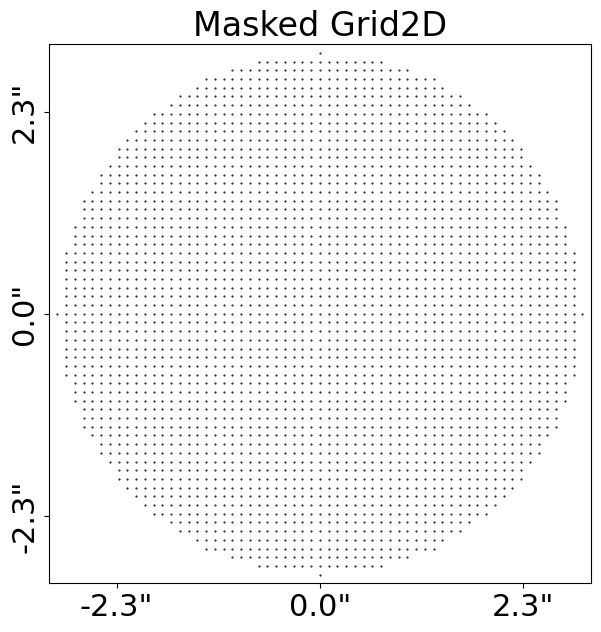

In [13]:
masked_grid = mask.derive_grid.unmasked

grid_plotter = aplt.Grid2DPlotter(grid=masked_grid)
grid_plotter.set_title("Masked Grid2D")
grid_plotter.figure_2d()

By plotting this masked grid over the galaxy image, we can see that the grid aligns with the unmasked pixels of the 
image.

This alignment **is crucial** for accurate fitting because it ensures that when we evaluate a galaxy's light profile, 
the calculations occur only at positions where we have real data from.

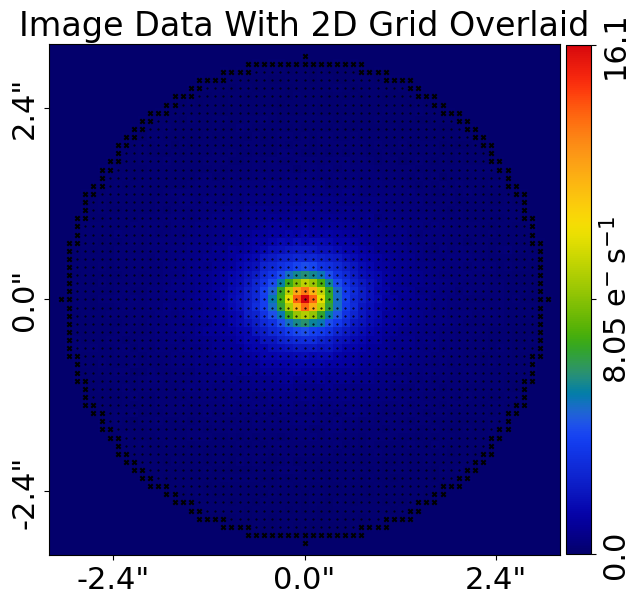

In [14]:
visuals = aplt.Visuals2D(grid=masked_grid)
imaging_plotter = aplt.ImagingPlotter(dataset=dataset, visuals_2d=visuals)
imaging_plotter.set_title("Image Data With 2D Grid Overlaid")
imaging_plotter.figures_2d(data=True)

__Fitting__

Now that our data is masked, we are ready to proceed with the fitting process.

Fitting the data is done using the `Galaxy` and `Galaxies objects that we introduced in tutorial 2. We will start by 
setting up a `Galaxies`` object, using the same galaxy configuration that we previously used to simulate the 
imaging data. This setup will give us what is known as a 'perfect' fit, as the simulated and fitted models are identical.

In [15]:
galaxy = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.0, 0.0),
        ell_comps=(0.0, 0.111111),
        intensity=1.0,  # in units of e- pix^-1 s^-1
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

galaxies = ag.Galaxies(galaxies=[galaxy])

Next, let's plot the image of the galaxies. This should look familiar, as it is the same image we saw in 
previous tutorials. The difference now is that we use the dataset's `grid`, which corresponds to the `masked_grid` 
we defined earlier. This means that the galaxy image is only evaluated in the unmasked region, skipping calculations 
in masked regions.

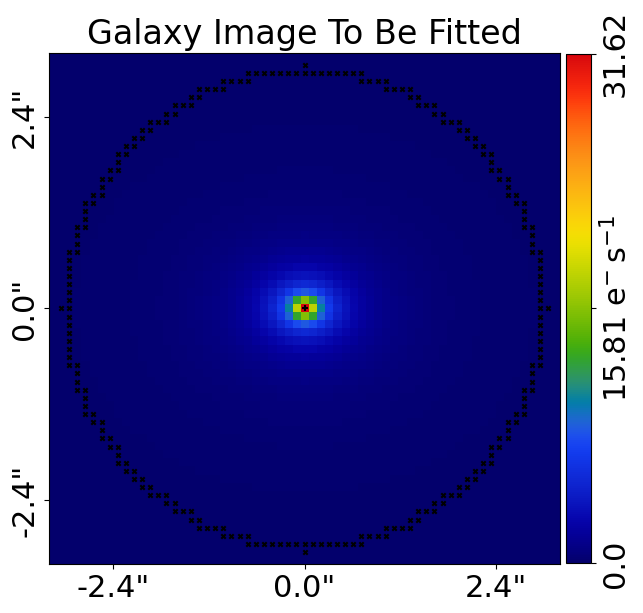

In [16]:
galaxies_plotter = aplt.GalaxiesPlotter(galaxies=galaxies, grid=dataset.grid)
galaxies_plotter.set_title("Galaxy Image To Be Fitted")
galaxies_plotter.figures_2d(image=True)

Now, we proceed to fit the image by passing both the `Imaging` and `Galaxies` objects to a `FitImaging` object. 
This object will compute key quantities that describe the fit’s quality:

`image`: Creates an image of the galaxies using their image_2d_from() method.
`model_data`: Convolves the galaxy image with the data's PSF to account for the effects of telescope optics.
`residual_map`: The difference between the model data and observed data.
`normalized_residual_map`: Residuals divided by noise values, giving units of noise.
`chi_squared_map`: Squares the normalized residuals.
`chi_squared` and `log_likelihood`: Sums the chi-squared values to compute chi_squared, and converts this into 
a log_likelihood, which measures how well the model fits the data (higher values indicate a better fit).

Let's create the fit and inspect each of these attributes:

In [17]:
fit = ag.FitImaging(dataset=dataset, galaxies=galaxies)
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)

The `model_data` represents the galaxy's image after accounting for effects like PSF convolution. 

An important technical note is that when we mask data, we discussed above how the image of the galaxy is not evaluated
outside the mask and is set to zero. This is a problem for PSF convolution, as the PSF blurs light from these regions
outside the mask but at its edge into the mask. They must be correctly evaluated to ensure the model image accurately
represents the image data.

The `FitImaging` object handles this internally, but evaluating the model image in the additional regions outside the mask
that are close enough to the mask edge to be blurred into the mask. 

First model image pixel:
0.05484586544288773


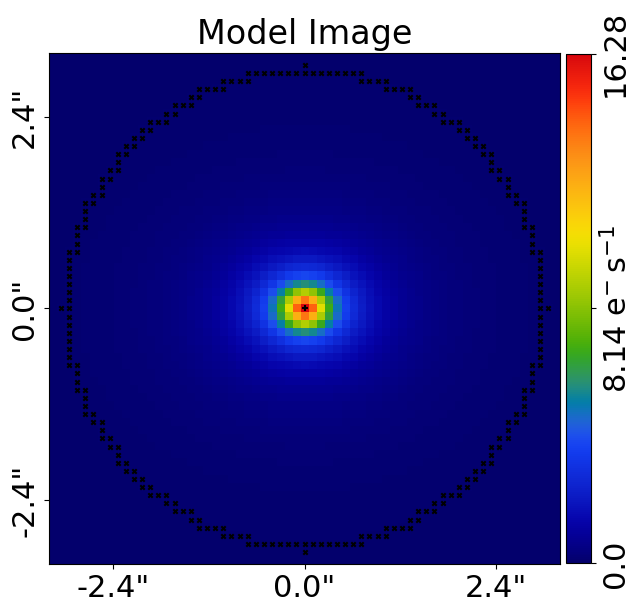

In [18]:
print("First model image pixel:")
print(fit.model_data.slim[0])
fit_imaging_plotter.figures_2d(model_image=True)

Even before computing other fit quantities, we can normally assess if the fit is going to be good by visually comparing
the `data` and `model_data` and assessing if they look similar.

In this example, the galaxies used to fit the data are the same as the galaxies used to simulate it, so the two
look very similar (the only difference is the noise in the image).

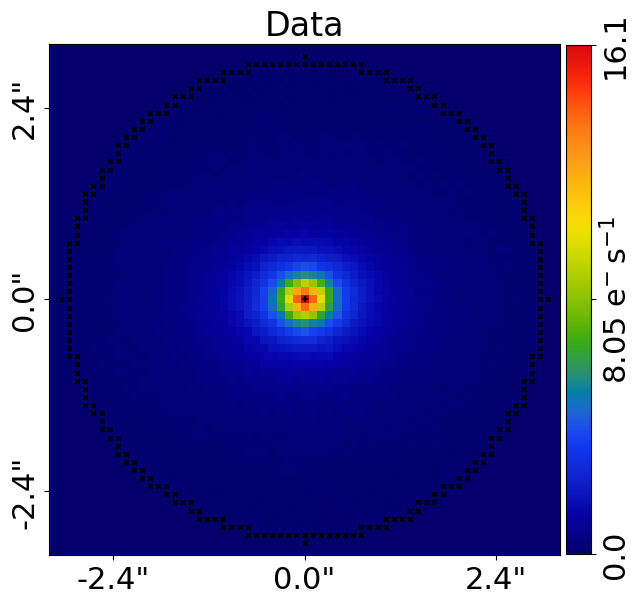

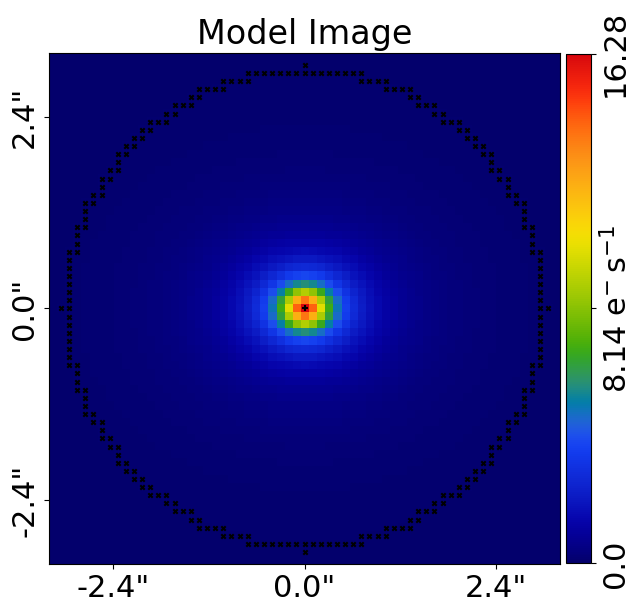

In [19]:
fit_imaging_plotter.figures_2d(data=True)
fit_imaging_plotter.figures_2d(model_image=True)

The `residual_map` is the different between the observed image and model image, showing where in the image the fit is
good (e.g. low residuals) and where it is bad (e.g. high residuals).

The expression for the residual map is simply:

\[ \text{residual} = \text{data} - \text{model\_data} \]

The residual-map is plotted below, noting that all values are very close to zero because the fit is near perfect.
The only non-zero residuals are due to noise in the image.

First residual-map pixel:
0.044862812012812246
First residual-map pixel via fit:
0.044862812012812246


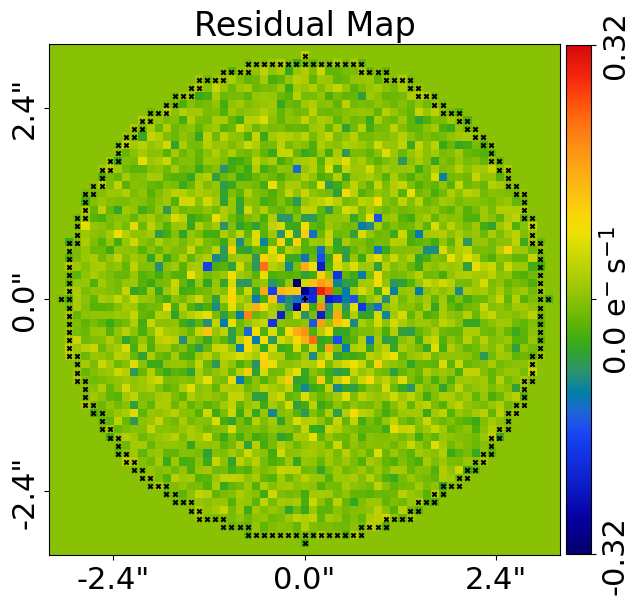

In [20]:
residual_map = dataset.data - fit.model_data
print("First residual-map pixel:")
print(residual_map.slim[0])

print("First residual-map pixel via fit:")
print(fit.residual_map.slim[0])

fit_imaging_plotter.figures_2d(residual_map=True)

Are these residuals indicative of a good fit to the data? Without considering the noise in the data, it's difficult 
to ascertain. That is, its hard to ascenrtain if a residual value is large or small because this depends on the
amount of noise in that pixel.

The `normalized_residual_map` divides the residual-map by the noise-map, giving the residual in units of the noise.
Its expression is:

\[ \text{normalized\_residual} = \frac{\text{residual\_map}}{\text{noise\_map}} = \frac{\text{data} - \text{model\_data}}{\text{noise\_map}} \]

If you're familiar with the concept of standard deviations (sigma) in statistics, the normalized residual map represents 
how many standard deviations the residual is from zero. For instance, a normalized residual of 2.0 (corresponding 
to a 95% confidence interval) means that the probability of the model underestimating the data by that amount is only 5%.

First normalized residual-map pixel:
1.738796075629591
First normalized residual-map pixel via fit:
1.738796075629591


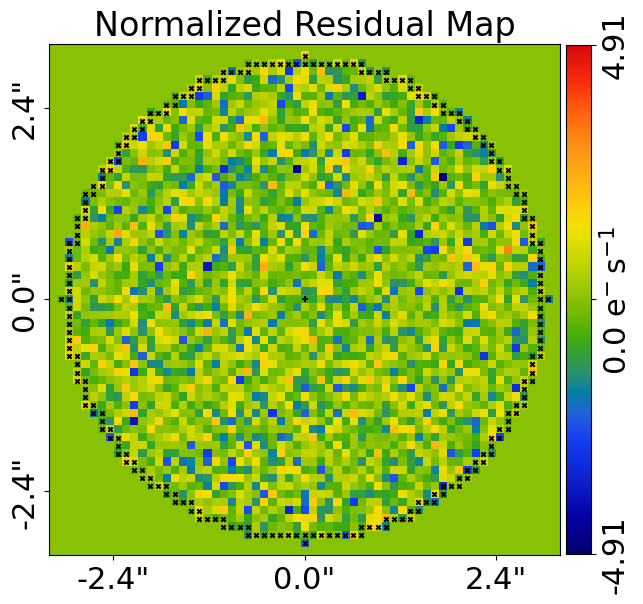

In [21]:
normalized_residual_map = residual_map / dataset.noise_map

print("First normalized residual-map pixel:")
print(normalized_residual_map.slim[0])

print("First normalized residual-map pixel via fit:")
print(fit.normalized_residual_map.slim[0])

fit_imaging_plotter.figures_2d(normalized_residual_map=True)

Next, we define the `chi_squared_map`, which is obtained by squaring the `normalized_residual_map` and serves as a 
measure of goodness of fit.

The chi-squared map is calculated as:

\[ \chi^2 = \left(\frac{\text{data} - \text{model\_data}}{\text{noise\_map}}\right)^2 \]

Squaring the normalized residual map ensures all values are positive. For instance, both a normalized residual of -0.2 
and 0.2 would square to 0.04, indicating the same quality of fit in terms of `chi_squared`.

As seen from the normalized residual map, it's evident that the model provides a good fit to the data, in this
case because the chi-squared values are close to zero.

First chi-squared pixel:
3.0234117926248665
First chi-squared pixel via fit:
3.0234117926248665


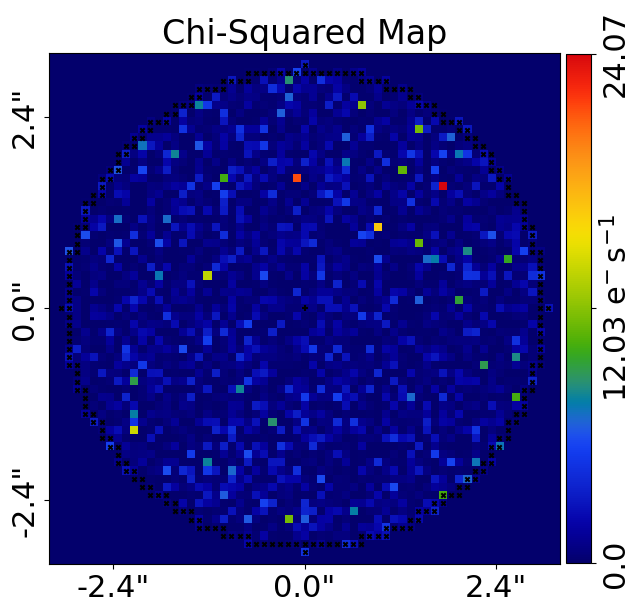

In [22]:
chi_squared_map = (normalized_residual_map) ** 2
print("First chi-squared pixel:")
print(chi_squared_map.slim[0])

print("First chi-squared pixel via fit:")
print(fit.chi_squared_map.slim[0])

fit_imaging_plotter.figures_2d(chi_squared_map=True)

Now, we consolidate all the information in our `chi_squared_map` into a single measure of goodness-of-fit 
called `chi_squared`. 

It is defined as the sum of all values in the `chi_squared_map` and is computed as:

\[ \chi^2 = \sum \left(\frac{\text{data} - \text{model\_data}}{\text{noise\_map}}\right)^2 \]

This summing process highlights why ensuring all values in the chi-squared map are positive is crucial. If we 
didn't square the values (making them positive), positive and negative residuals would cancel each other out, 
leading to an inaccurate assessment of the model's fit to the data.

The lower the `chi_squared`, the fewer residuals exist between the model's fit and the data, indicating a better 
overall fit!

In [23]:
chi_squared = np.sum(chi_squared_map)
print("Chi-squared = ", chi_squared)
print("Chi-squared via fit = ", fit.chi_squared)

Chi-squared =  2899.498149977297
Chi-squared via fit =  2899.498149977297


The reduced chi-squared is the `chi_squared` value divided by the number of data points (e.g., the number of pixels
in the mask). 

This quantity offers an intuitive measure of the goodness-of-fit, as it normalizes the `chi_squared` value by the
number of data points. That is, a reduced chi-squared of 1.0 indicates that the model provides a good fit to the data,
because every data point is fitted with a chi-squared value of 1.0.

A reduced chi-squared value significantly greater than 1.0 indicates that the model is not a good fit to the data,
whereas a value significantly less than 1.0 suggests that the model is overfitting the data.

In [24]:
reduced_chi_squared = chi_squared / dataset.mask.pixels_in_mask
print("Reduced Chi-squared = ", reduced_chi_squared)

Reduced Chi-squared =  1.0307494312041583


Another quantity that contributes to our final assessment of the goodness-of-fit is the `noise_normalization`.

The `noise_normalization` is computed as the logarithm of the sum of squared noise values in our data: 

\[
\text{{noise\_normalization}} = \sum \log(2 \pi \text{{noise\_map}}^2)
\]

This quantity is fixed because the noise-map remains constant throughout the fitting process. Despite this, 
including the `noise_normalization` is considered good practice due to its statistical significance.

Understanding the exact meaning of `noise_normalization` isn't critical for our primary goal of successfully 
fitting a model to a dataset. Essentially, it provides a measure of how well the noise properties of our data align 
with a Gaussian distribution.

In [25]:
noise_normalization = np.sum(np.log(2 * np.pi * dataset.noise_map**2))
print("Noise Normalization = ", noise_normalization)
print("Noise Normalization via fit = ", fit.noise_normalization)

Noise Normalization =  -13561.598901697917
Noise Normalization via fit =  -13561.598901697917


From the `chi_squared` and `noise_normalization`, we can define a final goodness-of-fit measure known as 
the `log_likelihood`. 

This measure is calculated by taking the sum of the `chi_squared` and `noise_normalization`, and then multiplying the 
result by -0.5:

\[ \text{log\_likelihood} = -0.5 \times \left( \chi^2 + \text{noise\_normalization} \right) \]

Don't worry about why we multiply by -0.5; it's a standard practice in statistics to ensure the log likelihood is
defined correctly.

In [26]:
log_likelihood = -0.5 * (chi_squared + noise_normalization)
print("Log Likelihood = ", log_likelihood)
print("Log Likelihood via fit = ", fit.log_likelihood)

Log Likelihood =  5331.05037586031
Log Likelihood via fit =  5331.05037586031


In the previous discussion, we noted that a lower \(\chi^2\) value indicates a better fit of the model to the 
observed data. 

When we calculate the log likelihood, we take the \(\chi^2\) value and multiply it by -0.5. This means that a 
higher log likelihood corresponds to a better model fit. Our goal when fitting models to data is to maximize the 
log likelihood.

The **reduced \(\chi^2\)** value provides an intuitive measure of goodness-of-fit. Values close to 1.0 suggest a 
good fit, while values below or above 1.0 indicate potential underfitting or overfitting of the data, respectively. 
In contrast, the log likelihood values can be less intuitive. For instance, a log likelihood value printed above 
might be around 5300.

However, log likelihoods become more meaningful when we compare them. For example, if we have two models, one with 
a log likelihood of 5300 and the other with 5310 we can conclude that the first model fits the data better 
because it has a higher log likelihood by 10.0. 

In fact, the difference in log likelihood between models can often be associated with a probability indicating how 
much better one model fits the data compared to another. This can be expressed in terms of standard deviations (sigma). 

As a rule of thumb:

- A difference in log likelihood of **2.5** suggests that one model is preferred at the **2.0 sigma** level.
- A difference in log likelihood of **5.0** indicates a preference at the **3.0 sigma** level.
- A difference in log likelihood of **10.0** suggests a preference at the **5.0 sigma** level.

All these metrics can be visualized together using the `FitImagingPlotter` object, which offers a comprehensive 
overview of the fit quality.

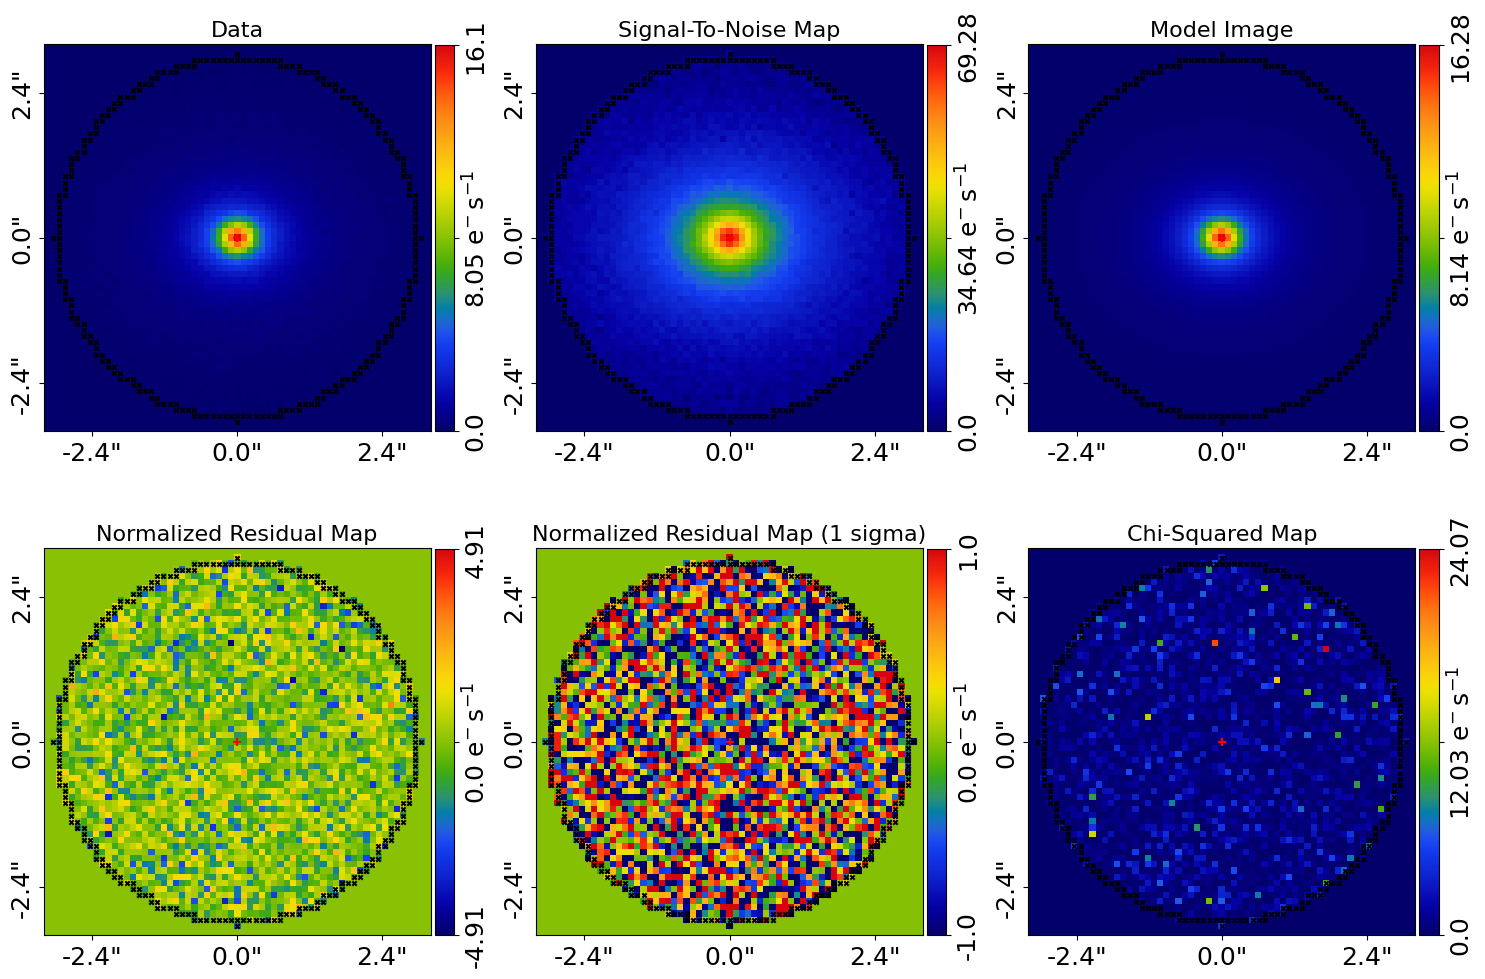

In [27]:
fit = ag.FitImaging(dataset=dataset, galaxies=galaxies)

fit_bad_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
fit_bad_imaging_plotter.subplot_fit()

If you're familiar with model-fitting, you've likely encountered terms like 'residuals', 'chi-squared', 
and 'log_likelihood' before. 

These metrics are standard ways to quantify the quality of a model fit. They are applicable not only to 1D data but 
also to more complex data structures like 2D images, 3D data cubes, or any other multidimensional datasets.

__Incorrect Fit___

In the previous section, we successfully created and fitted a galaxy model to the image data, resulting in an 
excellent fit. The residual map and chi-squared map showed no significant discrepancies, indicating that the 
galaxy's light was accurately captured by our model. This optimal solution translates to one of the highest log 
likelihood values possible, reflecting a good match between the model and the observed data.

Now, let's modify our galaxy model to create a fit that is close to the correct solution but slightly off. 
Specifically, we will slightly offset the center of the galaxy by half a pixel (0.05") in both the x and y directions. 
This change will allow us to observe how even small deviations from the true parameters can impact the quality of the fit.

In [28]:
galaxy = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.05, 0.05),  # This is different from the previous center.
        ell_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

galaxies = ag.Galaxies(galaxies=[galaxy])

After implementing this slight adjustment, we can now plot the fit. In doing so, we observe that residuals have 
emerged at the center of the galaxy, which indicates a mismatch between our model and the data. Consequently, 
this discrepancy results in increased chi-squared values, which in turn affects our log likelihood.

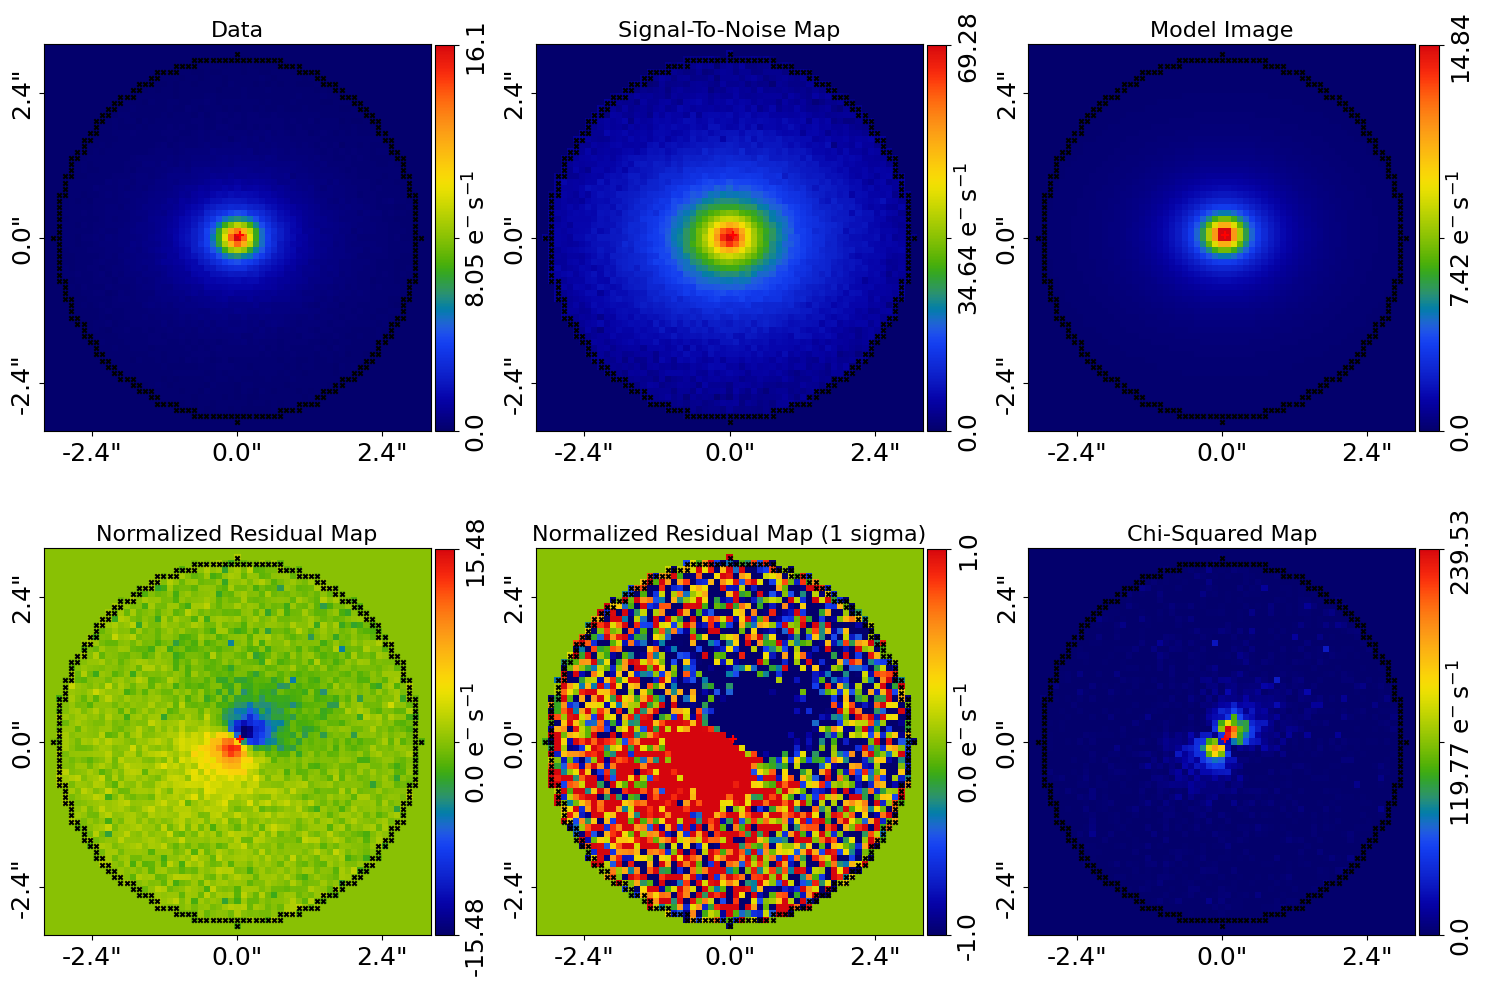

In [29]:
fit_bad = ag.FitImaging(dataset=dataset, galaxies=galaxies)

fit_bad_imaging_plotter = aplt.FitImagingPlotter(fit=fit_bad)
fit_bad_imaging_plotter.subplot_fit()

Next, we can compare the log likelihood of our current model to the log likelihood value we computed previously.

In [30]:
print("Previous Likelihood:")
print(fit.log_likelihood)
print("New Likelihood:")
print(fit_bad.log_likelihood)

Previous Likelihood:
5331.05037586031
New Likelihood:
1640.2953117822208


As expected, we observe that the log likelihood has decreased! This decline confirms that our new model is indeed a 
worse fit to the data compared to the original model.

Now, let’s change our galaxy model once more, this time setting it to a position that is far from the true parameters. 
We will offset the galaxy's center significantly to see how this extreme deviation affects the fit quality.

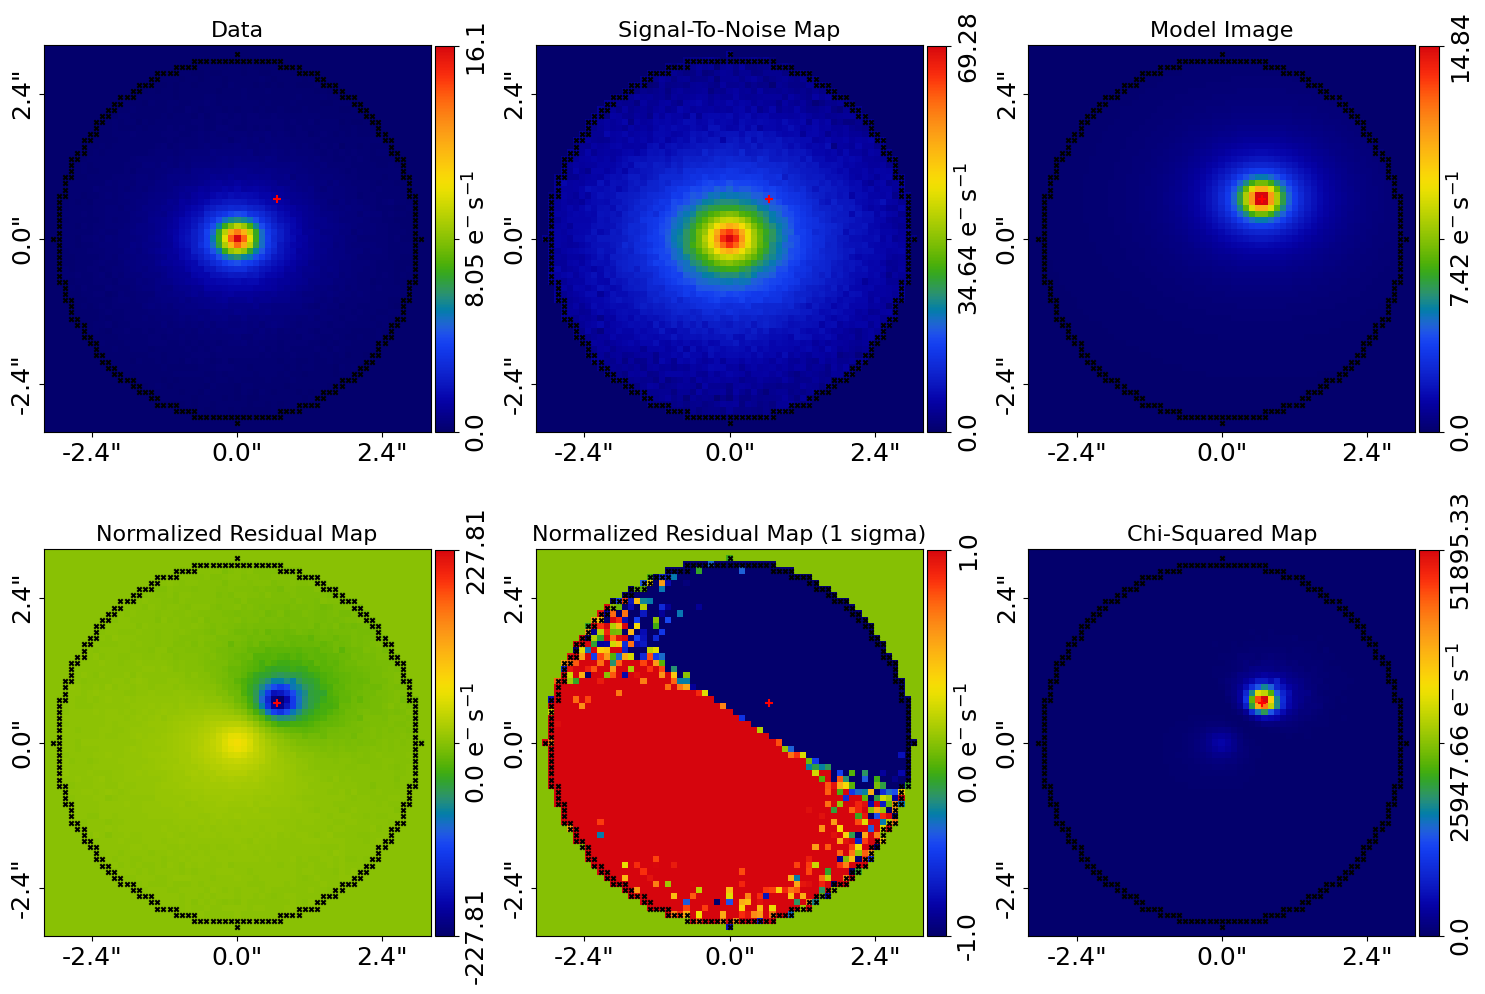

In [31]:
galaxy = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(
            0.65,
            0.65,
        ),  # This position is significantly different from the previous one.
        ell_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

galaxies = ag.Galaxies(galaxies=[galaxy])

fit_very_bad = ag.FitImaging(dataset=dataset, galaxies=galaxies)

fit_very_bad_imaging_plotter = aplt.FitImagingPlotter(
    fit=fit_very_bad,
)
fit_very_bad_imaging_plotter.subplot_fit()

It is now evident that this model provides a terrible fit to the data. The galaxies do not resemble a plausible 
representation of our simulated galaxy dataset, which we already anticipated given that we generated the data ourselves!

As expected, the log likelihood has dropped dramatically with this poorly fitting model.

In [32]:
print("Previous Likelihoods:")
print(fit.log_likelihood)
print(fit_bad.log_likelihood)
print("New Likelihood:")
print(fit_very_bad.log_likelihood)

Previous Likelihoods:
5331.05037586031
1640.2953117822208
New Likelihood:
-538282.3751155408


__Model Fitting__

In the previous sections, we used the true model to fit the data, which resulted in a high log likelihood and minimal 
residuals. We also demonstrated how even small deviations from the true parameters can significantly degrade the fit 
quality, reducing the log likelihood.

In practice, however, we don't know the "true" model. For example, we might have an image of a galaxy observed with 
the Hubble Space Telescope, but the values for parameters like its `effective_radius`, `sersic_index`, and others are 
unknown. The process of determining the best-fit model is called model fitting, and it is the main topic of 
the next tutorial.

To conclude this section, let's perform a basic, hands-on model fit to develop some intuition about how we can find 
the best-fit model. We'll start by loading a simple dataset that was simulated using a `Sersic` profile, where the 
true parameters of this profile are unknown, and masking it to again exclude regions with low signal.

2024-10-30 12:09:43,716 - autoarray.dataset.imaging.dataset - INFO - IMAGING - Data masked, contains a total of 2828 image-pixels


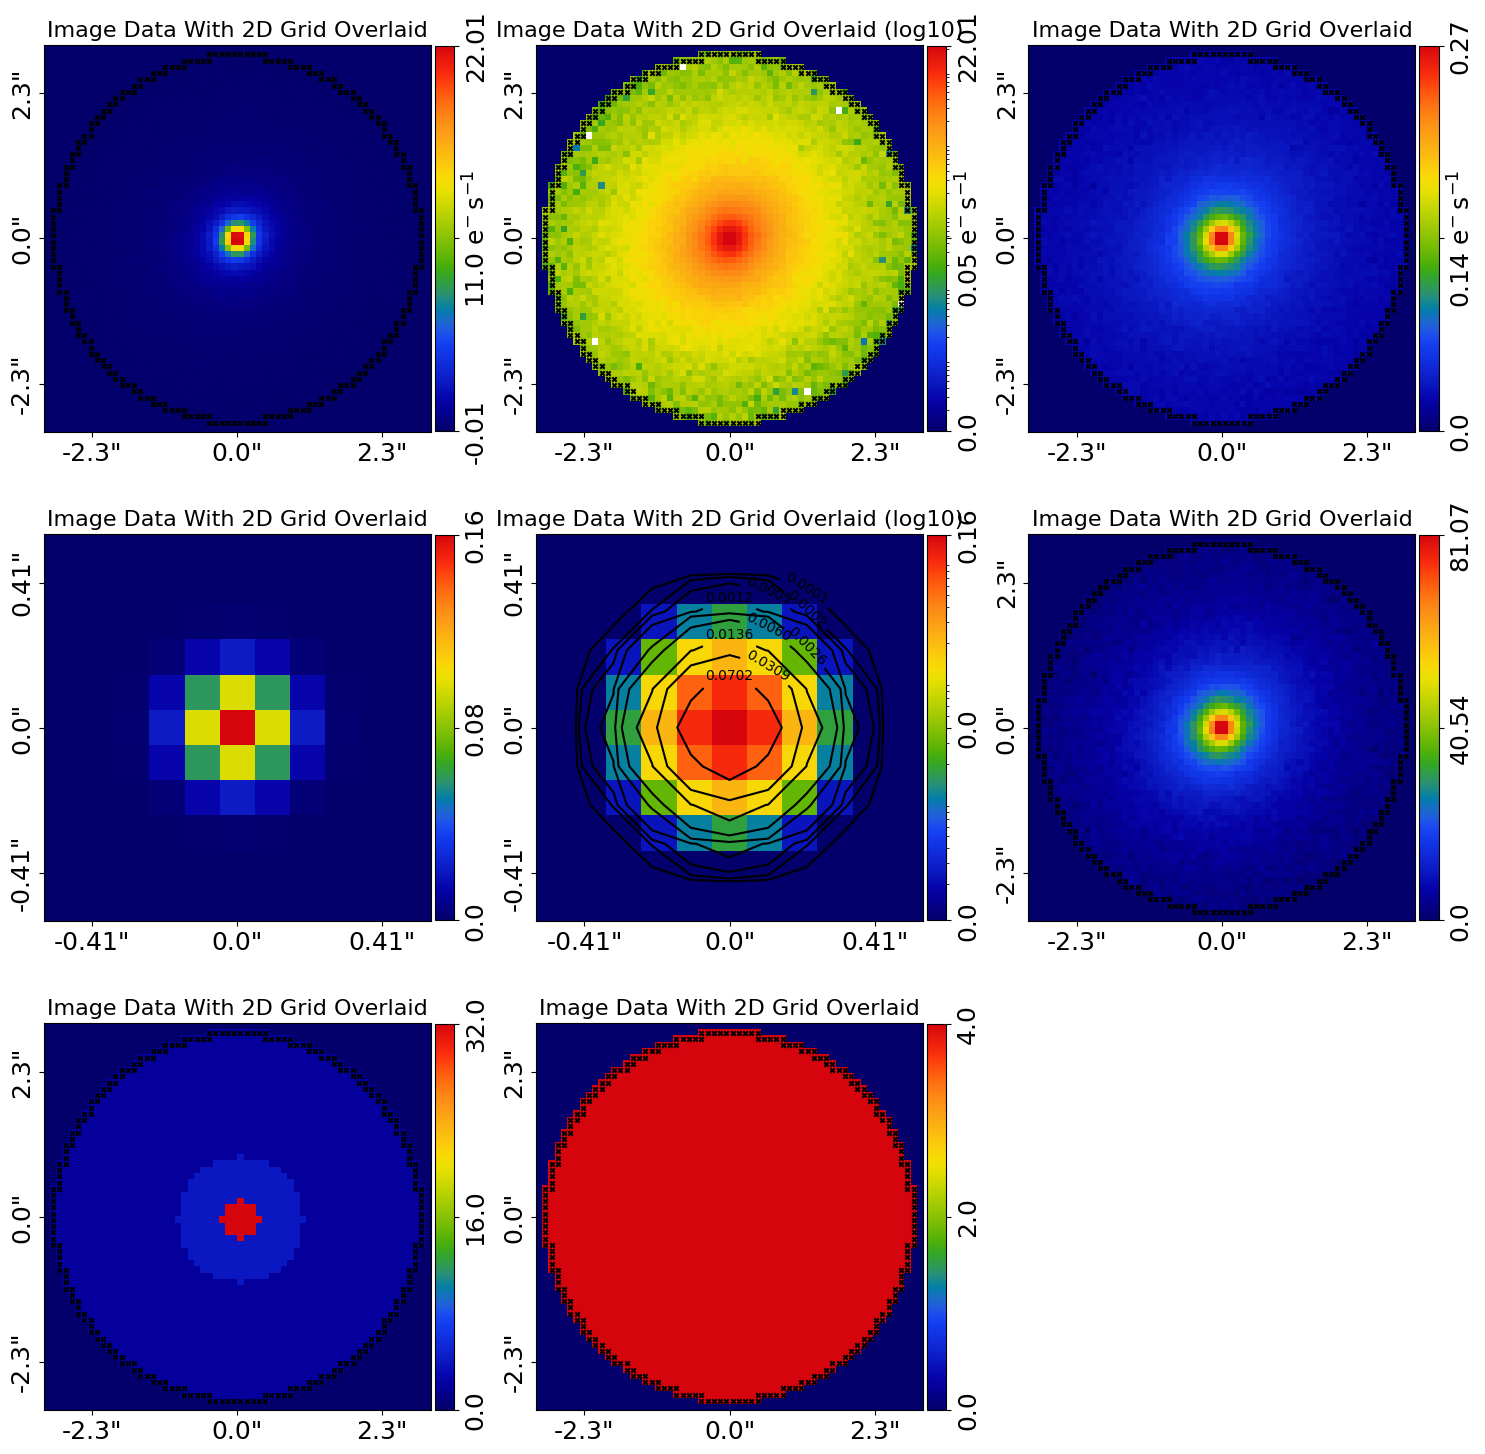

In [33]:
dataset_name = "simple__sersic"
dataset_path = path.join("dataset", "imaging", dataset_name)

dataset = ag.Imaging.from_fits(
    data_path=path.join(dataset_path, "data.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

mask = ag.Mask2D.circular(
    shape_native=dataset.shape_native,
    pixel_scales=dataset.pixel_scales,
    radius=3.0,
)

dataset = dataset.apply_mask(mask=mask)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.subplot_dataset()


Now, you'll try to determine the best-fit model for this image, corresponding to the parameters used to simulate the 
dataset.

We'll use the simplest possible approach: try different combinations of light profile parameters and adjust them 
based on how well each model fits the data. You’ll quickly find that certain parameters produce a much better fit 
than others. For example, determining the correct values of the `centre` should not take too long.

Pay attention to the `log_likelihood` and the `residual_map` as you adjust the parameters. These will guide you in 
determining if your model is providing a good fit to the data. Aim to increase the log likelihood and reduce the 
residuals.

Keep experimenting with different values for a while, seeing how small you can make the residuals and how high you 
can push the log likelihood. Eventually, you’ll likely reach a point where further improvements become difficult, 
even after trying many different parameter values. This is a good point to stop and reflect on your first experience 
with model fitting, and then to scroll to the next cell to see a discussion of the exercise.

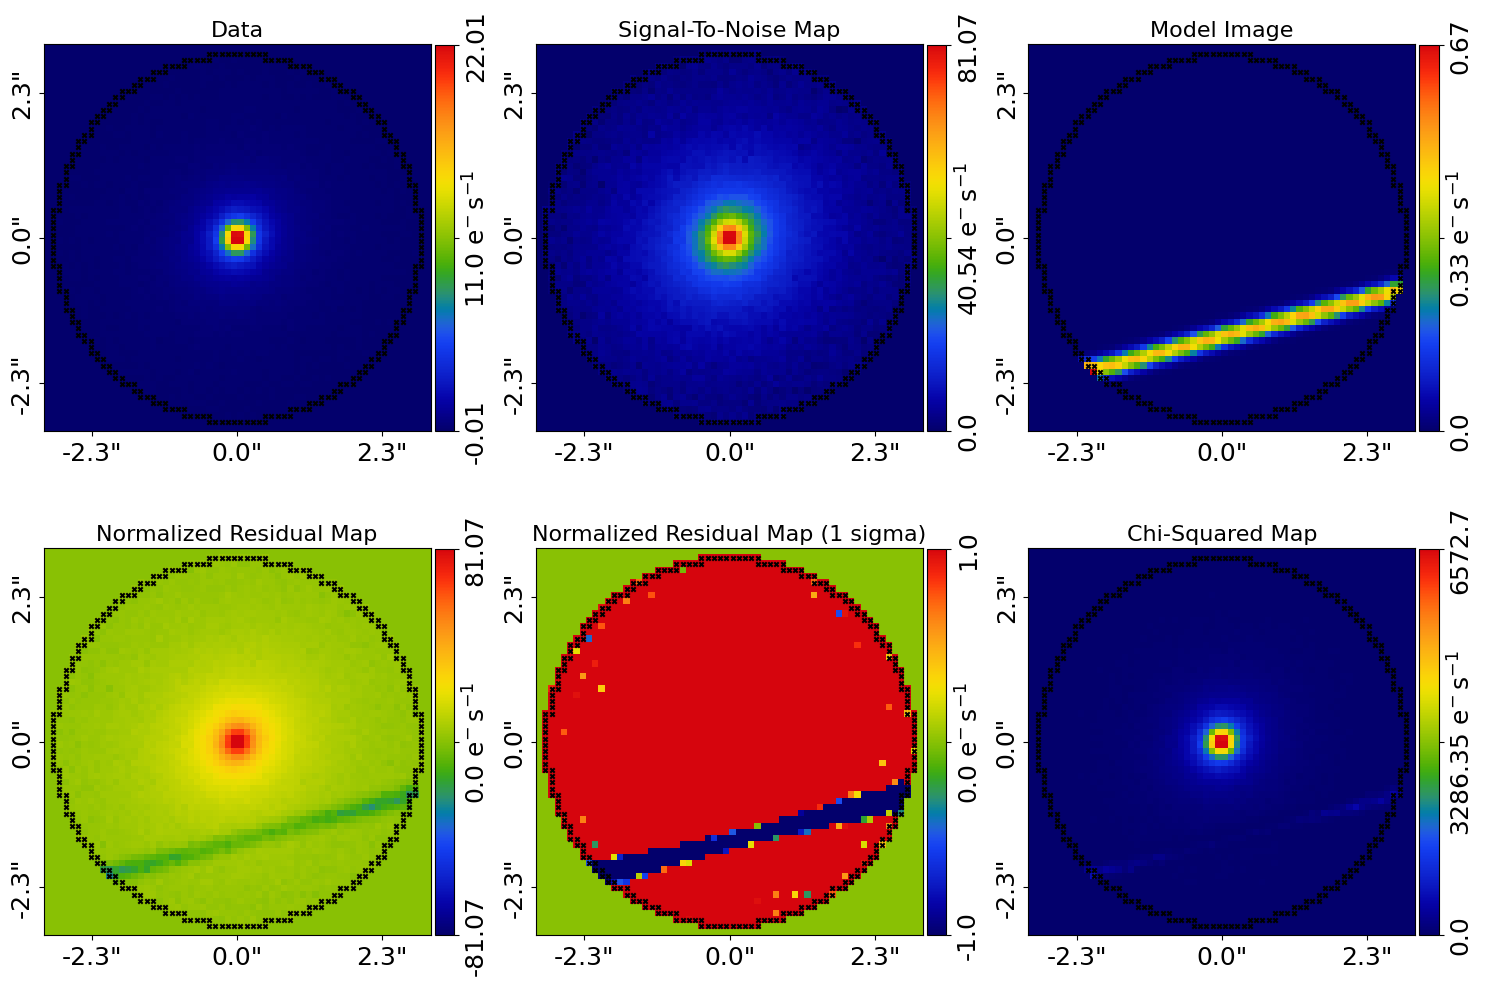

Log Likelihood:
-154153.34045156353


In [34]:
galaxy = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(1.0, 10),  # These are the parameters
        ell_comps=(0.5, 0.9),  # you need to adjust
        intensity=1.0,  # to try and improve
        effective_radius=1.0,  #  the model's fit
        sersic_index=1.0,  # to the data!
    ),
)

galaxies = ag.Galaxies(galaxies=[galaxy])

fit = ag.FitImaging(dataset=dataset, galaxies=galaxies)

fit_plotter = aplt.FitImagingPlotter(fit=fit)
fit_plotter.subplot_fit()

print("Log Likelihood:")
print(fit.log_likelihood)

Manually guessing model parameters repeatedly is a very inefficient and slow way to find the best fit. If the model 
were more complex—say, if the `galaxy` had additional light profile components beyond just its `bulge` (like a 
second `Sersic` profile representing a `disk`)—the model would become so intricate that this manual approach 
would be practically impossible. This is definitely not how model fitting is done in practice.

However, this exercise has given you a basic intuition for how model fitting works. The statistical inference tools 
that are actually used for model fitting will be introduced in Chapter 2. Interestingly, these tools are not entirely 
different from the approach you just tried. Essentially, they also involve iteratively testing models until those 
with high log likelihoods are found. The key difference is that a computer can perform this process thousands of 
times, and it does so in a much more efficient and strategic way.

__Wrap Up__

In this tutorial, you have learned how to fit a galaxy model to imaging data, a fundamental process in astronomy
and statistical inference. 

Let's summarize what we have covered:

- **Dataset**: We loaded the imaging dataset that we previously simulated, consisting of the galaxy image, noise map,
  and PSF.
  
- **Mask**: We applied a circular mask to the data, excluding regions with low signal-to-noise ratios from the analysis.

- **Masked Grid**: We created a masked grid, which contains only the coordinates of unmasked pixels, to evaluate the
  galaxy's light profile.
  
- **Fitting**: We fitted the data with a galaxy model, computing key quantities like the model image, residuals,
  chi-squared, and log likelihood to assess the quality of the fit.
  
- **Bad Fits**: We demonstrated how even small deviations from the true parameters can significantly impact the fit
  quality, leading to decreased log likelihood values.
  
- **Model Fitting**: We performed a basic model fit on a simple dataset, adjusting the model parameters to improve the
  fit quality.